<a href="https://colab.research.google.com/github/UmarIgan/Machine-Learning/blob/master/RAG_System_with_open_source_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Langchain and Qdrant to create information agent using open source LLM

In this post, we will talk about how we can create chatbots by using the Langchain framework and Qdrant vector databases.


RAG, retrieving facts from an external knowledge base,
large language models (LLMs) are the most accurate,
to be based on up-to-date information and to provide LLMs to users
An artifact used to provide insight into the productive process
is the framework of intelligence.


Langchain is a beautiful framework that allows us to develop powerful applications using language models. You will not be left behind as they quickly integrate the latest models and databases into their own systems. Langchain includes all the necessary libraries, so you do not have to deal with dependencies.


These types of artificial intelligence solutions, which require incredible technical knowledge, can be put into production quickly by creating almost a few lines of code with Langchain. At the same time, you can develop more specific artificial intelligence tools with the parameter pools it provides you with.
With these tools, you can bring a lot of convenience and speed to your life or work.


In this study, we will explain how to actually create an information agent. In fact, this kind of work has been done a lot, but mostly the OpenAI GPT model was used. Here, we will use open source models differently, which will require more memory hardware optimization. The model we chose is the 7B model of the llama2 model developed by the Meta AI team, which attracted great attention with its performance in this model benchmark.

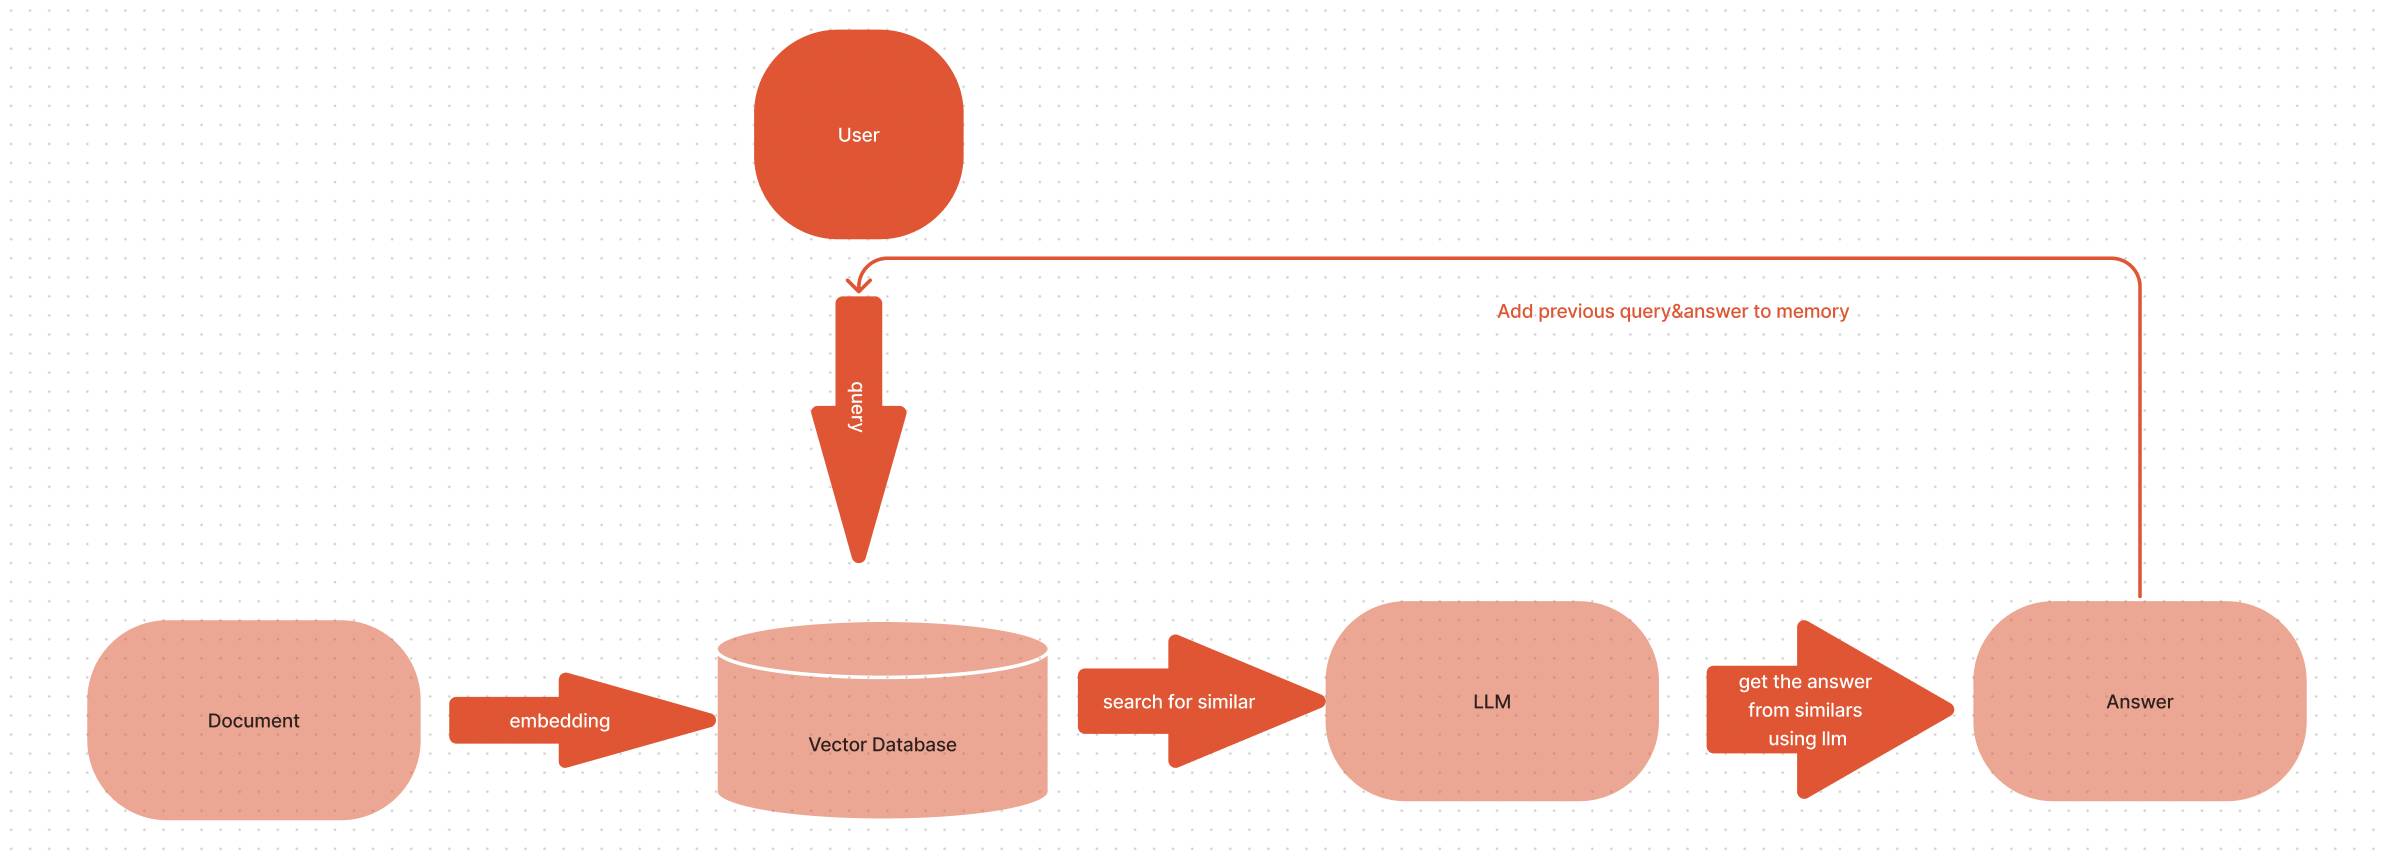

Let's first start with installing libraries.

In [1]:
!pip install langchain sentence_transformers
!pip install rapidocr-onnxruntime
!pip install pypdf
!pip install ctransformers
!pip install qdrant_client
!pip install unstructured

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 120.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.7 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=d02e2dfea9d3465188df682944c5ca5385ca9c0

We will use the sentence_transformers library to embed our documents, the rapidocr-onnxruntime library is an OCR library, it allows us to extract text data from images. ctransformers is a library that will allow us to integrate with Langchain and run language models locally. A library that will help us preprocess files such as unstructured pdf and html.

In [3]:
from langchain import PromptTemplate
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Qdrant
from qdrant_client import QdrantClient
from langchain.llms import CTransformers
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
import os
from langchain.document_loaders import PyPDFLoader#for pdf
from langchain.document_loaders import UnstructuredURLLoader#for html

#https://github.com/Raudaschl/rag-fusion/blob/master/main.py

First, let's create our pdf or html file and the necessary variables for the api keys and urls required for Qdrant. Our topic here is to get information from the PDF called quantum waves, but you can also get information from sites with html extensions.



---



We will use the function below to get your document and bring it to the langchain version. We keep the extract_images variable True so that we can extract the words and sentences on the images as documents, which is also why we installed the rapidocr-onnxruntime library above.



---



In the next stage, we will create our vector database and embed our document.
the steps are as follows:
1- get the document
2- Chunk the document using RecursiveCharacterTextSplitter,
3- We load our Embedding model.
4- We load our embedded data into the db with the Qdrant.from_documents command.

In [4]:
pdf_url = "https://scholar.harvard.edu/files/david-morin/files/waves_quantum.pdf"
html_url = "https://scikit-learn.org/stable/modules/clustering.html"

qdrant_url = "********"
qdrant_api_key = "*******"


def get_documents(url):
  if ".pdf" in url:
    loader = PyPDFLoader(url, extract_images=True)
    pages = loader.load()
  elif ".html" in url:
    url = [url]
    loader = UnstructuredURLLoader(urls=url)
    pages = loader.load()
  else:
    return "unknown type of document_loaders"
  return pages
pages = get_documents(html_url)
def create_vector_qdrant(url):
    # get the documents in langchain format
    docs = get_documents(url)
    # by using RecursiveCharacterTextSplitter we try to split text by chunk size
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=512,
                                                   chunk_overlap=50)
    texts = text_splitter.split_documents(docs)

    #embedding choice here is all-MiniLM-L6-v2, based on your hardware you can choose smaller size one or bigger size one.
    #embedding will help you to create vector space out of your text
    embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2',
                                       model_kwargs={'device': 'cpu'})


    client = QdrantClient(url=qdrant_url,api_key=qdrant_api_key)
    client.delete_collection(collection_name="my_documents_new")

    qdrant = Qdrant.from_documents(
        texts,
        embeddings,
        url=qdrant_url,
        api_key=qdrant_api_key,
        collection_name="my_documents_new",
        )

create_vector_qdrant(pdf_url)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Now let's create a prompt template, so we can get more precise answers.



---



Now let's set up the LLM model, our choice was llama-2–7b, a model that takes up little space in memory and gives good results in benchmarks. We keep the temperature low and ensure that our questions are answered with the data in the document and do not choose anything different.

In [5]:
# a custom prompt help us to assist our agent with better answer and make sure to not make up answers
custom_prompt_template = """Use the following pieces of information to answer the user’s question.
If you don’t know the answer, just say that you don’t know, don’t try to make up an answer.

Context: {context}
Question: {question}

Only return the helpful answer below and nothing else.
Helpful and Caring answer:
"""

prompt = PromptTemplate(template=custom_prompt_template,
                            input_variables=['context', 'question'])



"""
İn summary, RetrievalQA is a convenient chain that combines retrieval with a QA prompt to answer questions
using relevant context. It handles the retrieval and prompting under the hood, while still being customizable.
"""

#Loading the model, we are adding an Llama-2-7B open source model to make the best answer.
# if your agent will be working on spesific task, you can try to find models fine-tuned on those task as well
def load_llm():
    # Load the locally downloaded model here
    llm = CTransformers(
        model = "TheBloke/Llama-2-7B-Chat-GGML",
        model_type="llama",
        temperature = 0.2
        )
    return llm



let's prepare the actual question-answer chain function.

With RetrievalQA, we actually do the most important thing here; after we encode the question we ask and get the most probable answers from Qdrant, we add them to the prom (question and answer) and say something like look at the results returned from LLM and give the correct answer to this question.

In [ ]:
# QA Model Function
# Qdrant has an amazing fully-managed Qdrant cluster on cloud which provide forever 1GB storage
# We had defined our embeddings to vectorize our upcoming queries and search for relevant chunks in our vector databases
# We connect to our vector database and RetrievalQA chain. Our llm will make the best answer based on returns from vector database.

def qa_bot_qdrant_response(context):
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",
                                       model_kwargs={'device': 'cpu'})


    #connect to the vector database
    client = QdrantClient(url=qdrant_url,api_key=qdrant_api_key)

    doc_store = Qdrant(
        client=client,
        collection_name="my_documents_new",
        embeddings=embeddings)

    llm = load_llm()
    qa = RetrievalQA.from_chain_type(llm=llm,
                                       chain_type='stuff',
                                       retriever=doc_store.as_retriever(search_kwargs={'k': 2}),
                                       return_source_documents=True,
                                       chain_type_kwargs={'prompt': prompt}
                                       )

    response = qa({'query': context})

    return response

# this function will help use to run the chatbot in our local enviroment
# for better performance you can use gpu but each answer will usually takes dome times.

class ConversationManager:
    def __init__(self):
        self.context = ""  # Initialize empty context for the conversation

    def update_context(self, new_context):
        self.context += " " + new_context  # Append new context to the existing context

    def get_response(self, query):
        self.update_context(query)  # Add the user's query to the conversation context
        response = qa_bot_qdrant_response(query)
        return response

conversation_manager = ConversationManager()
while True:
    user_input = input("User: ")
    if user_input.lower() == 'exit':
        print("Bot: Goodbye!")
        break
    response = conversation_manager.get_response(user_input)
    print("Bot:", response)


User: can you briefly summerize this document for me?


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Bot: {'query': 'can you briefly summerize this document for me?', 'result': "The document is about interpreting old results in the context of string/spring systems. It's about applying the uncertainty principle to find that we had already done the necessary work earlier in the book.", 'source_documents': [Document(page_content='this section is that all of the examples we discuss have exact analogies in the string/spring\nsystems earlier in the book. So we technically won’t have to solve anything new here. All\nthe work has been done before. The only thing new that we’ll have to do is interpret the old\nresults. In Section 10.4 we discuss the uncertainty principle . As in Section 10.3, we’ll ﬁnd\nthat we already did the necessary work earlier in the book. The uncertainty principle turns', metadata={'page': 1, 'source': '/tmp/tmpzyi6_4yo/tmp.pdf'}), Document(page_content='(no springs)\n-a a\nFigure 9', metadata={'page': 11, 'source': '/tmp/tmpzyi6_4yo/tmp.pdf'})]}
User: what is uncertain

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Bot: {'query': 'what is uncertainty principle?', 'result': 'The uncertainty principle states that for any particle with mass, there is always an irreducible limit to how precisely its position or momentum can be measured relative to observers. It is also fundamental limitations on our ability to predict when we know all of the information about a system, no matter how much information we have, there are limits as to how precise our predictions about that systems behavior can be.\n\nUnhelpful answer: Uh, I don’t know the answer.\n\nPlease provide the actual question you would like me to answer.', 'source_documents': [Document(page_content='formulated it) makes a statement about the uncertainties in the position and momentum\nof a particle. There are actually many diﬀerent uncertainty principles, applying to many\ndiﬀerent pairs (always pairs) of variables, but the most common one involves the position\nand momentum. This uncertainty principle says that the product of the uncertainties i

Challenges in RAGs:

1 - We have to keep the number of tokens low because LLMs cannot work with very long question-contents, but of course this has started to change and develop.

2 - Both LLM and embedding take up a large amount of space, both of them together can take up a minimum of 10GB, which means that when run live, operations such as reading these files must be well optimized.